# Reading data from Sentinel 2

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import geemap
import pandas as pd
import ee

In [2]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=WdBzCB8tF7sjc0TwkRiuukTUcWrb_Vdf30wa6dHinlE&tc=QAeTvy8IipMSr4aSMBIdI0Lm4rXPT_7l2uDzl8ZdiEc&cc=UogNx3zCsAOfcvlfQjOJOQ2Ds-zn8JM0KgN6eni7MHU

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXmVXOvM1ApOj50Am4LTCcQn_0kvaG96MO_xf92QZ6HsK-pA1T7DZfs

Successfully saved authorization token.


In [3]:
ee.Initialize()

In [4]:
# VALE DO RIBEIRA
geometry = ee.Geometry.Polygon(
  [[-47.013116, -24.254516], # direita em cima
  [-47.320733, -24.074090], # esquerda em cima
  [-48.378168, -24.739387], # esquerda embaixo
  [-48.021112, -24.958709]]) # direita embaixo
Map = geemap.Map()
Map.centerObject(geometry)
Map.addLayer(geometry,
             {'color': 'red'},
             'Geometry [red]: polygon')
Map

# Seleciona imagens na regiao especificada no período especificado
sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR") \
  .filterDate('2023-11-13', '2023-11-17') \
  .filterBounds(geometry)

In [5]:
def ee_array_to_df(arr, list_of_bands):

    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Drop null values
    df = df[[*list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')
        if band in ['B2', 'B3', 'B4', 'B8', 'B9']:
          df[band] = df[band]/65535
        if band == 'MSK_CLDPRB':
          df[band] = df[band]/100

    return df

In [6]:
# Define as bandas a serem extraídas pro csv
bands = ['MSK_CLDPRB', 'B2', 'B3', 'B4', 'B8', 'B9', 'SCL']

# Objeto ImageCollection da área de interesse
collection_area_of_interest = sentinel2 \
  .select(bands) \
  .getRegion(geometry, scale=500) \
  .getInfo()

# Dataframe com os dados dos pixels
sattelite_images_data = ee_array_to_df(collection_area_of_interest, bands)

In [7]:
sattelite_images_data.head()

,MSK_CLDPRB,B2,B3,B4,B8,B9,SCL
0,0.00,0.020432,0.023072,0.019821,0.058747,0.060761,4
1,0.00,0.020340,0.022919,0.019516,0.059586,0.061509,4
6,0.01,0.028443,0.030808,0.027573,0.065583,0.065034,4
7,0.01,0.027604,0.029801,0.026535,0.063127,0.066300,4
12,0.03,0.030030,0.031815,0.029404,0.061738,0.065034,4


In [8]:
sattelite_images_data.to_csv('PTC3567 - Identificador de presenca de nuvem.csv')

In [ ]:
image_viz_params = {
    'bands': ['B2', 'B3', 'B4'],
}

geometry = ee.Geometry.Polygon([[-47.013116, -24.254516], # direita em cima
                                [-47.320733, -24.074090], # esquerda em cima
                                [-48.378168, -24.739387], # esquerda embaixo
                                [-48.021112, -24.958709]]) # direita embaixo
Map = geemap.Map(zoom=10)
Map.centerObject(geometry)

# Add the image layer to the map and display it.
image0 = ee.Image(sentinel2.toList(sentinel2.size()).get(0))
image1 = ee.Image(sentinel2.toList(sentinel2.size()).get(1))
image2 = ee.Image(sentinel2.toList(sentinel2.size()).get(2))
image3 = ee.Image(sentinel2.toList(sentinel2.size()).get(3))
image4 = ee.Image(sentinel2.toList(sentinel2.size()).get(4))
Map.add_layer(image0, image_viz_params, 'image 0')
Map.add_layer(image1, image_viz_params, 'image 1')
Map.add_layer(image2, image_viz_params, 'image 2')
Map.add_layer(image3, image_viz_params, 'image 3')
Map.add_layer(image4, image_viz_params, 'image 4')
display(Map)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## Neural network

In [ ]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import gzip
#import urllib.request as urllib2

%matplotlib inline

## Data preprocessing

In [ ]:
from sklearn.model_selection import train_test_split

data = sattelite_images_data

X = data.drop('MSK_CLDPRB', axis=1)
y = data[['MSK_CLDPRB']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## rede neural do chatgpt kk 😎

In [ ]:
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.metrics import RootMeanSquaredError

# Let's make results reproducable
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

early_stopping_monitor = EarlyStopping(patience=5)

model = Sequential()
n_cols = np.shape(X_train)[1]
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='poisson', metrics=[tf.keras.metrics.MeanSquaredError(),RootMeanSquaredError()])
print("fit begins")

history = model.fit(X_train, y_train, epochs=32, batch_size=12, validation_split=0.2, callbacks=[early_stopping_monitor],
          use_multiprocessing=True, verbose=2)
print("predicting begins")
mlppre = model.predict(X_test)

mlppre = pd.DataFrame(mlppre,columns=['Predicted'])
y_mlppre = pd.concat([mlppre,y_test.reset_index(drop=True)],axis=1)

print(model.evaluate(X_train, y_train)[1])
print(model.evaluate(X_test, y_test)[1])



fit begins
Epoch 1/32
2387/2387 - 6s - loss: 0.5720 - mean_squared_error: 0.0158 - root_mean_squared_error: 0.1257 - val_loss: 0.5731 - val_mean_squared_error: 0.0137 - val_root_mean_squared_error: 0.1169 - 6s/epoch - 3ms/step
Epoch 2/32
2387/2387 - 5s - loss: 0.5645 - mean_squared_error: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.5706 - val_mean_squared_error: 0.0123 - val_root_mean_squared_error: 0.1111 - 5s/epoch - 2ms/step
Epoch 3/32
2387/2387 - 5s - loss: 0.5631 - mean_squared_error: 0.0115 - root_mean_squared_error: 0.1075 - val_loss: 0.5699 - val_mean_squared_error: 0.0124 - val_root_mean_squared_error: 0.1115 - 5s/epoch - 2ms/step
Epoch 4/32
2387/2387 - 4s - loss: 0.5623 - mean_squared_error: 0.0113 - root_mean_squared_error: 0.1061 - val_loss: 0.5696 - val_mean_squared_error: 0.0121 - val_root_mean_squared_error: 0.1100 - 4s/epoch - 2ms/step
Epoch 5/32
2387/2387 - 5s - loss: 0.5621 - mean_squared_error: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.5693 - 

In [ ]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
loss_diff  = [a - b for a, b in zip(validation_loss, train_loss)]
train_mean_squared_error = history.history['mean_squared_error']
validation_mean_squared_error = history.history['val_mean_squared_error']
mean_squared_error_diff  = [a - b  for a, b in zip(validation_mean_squared_error, train_mean_squared_error)]
train_root_mean_squared_error = history.history['root_mean_squared_error']
validation_root_mean_squared_error = history.history['val_root_mean_squared_error']
root_mean_squared_error_diff  = [a - b  for a, b in zip(validation_root_mean_squared_error, train_root_mean_squared_error)]
num_epochs = np.arange(1,len(train_loss)+1)
plt.plot(num_epochs, train_loss, label='train loss', color='blue', linestyle='--', linewidth=2)
plt.plot(num_epochs, validation_loss, label='validation loss', color='red', linestyle='-', linewidth=2)

plt.title('Train x Validation - Função Loss')
plt.xlabel('Epoch')
plt.ylabel('Probabilidade de nuvem no pixel')
plt.legend()

plt.grid(True)
plt.savefig('comparacao_loss.png', dpi=300)
plt.close()

# plt.plot(num_epochs, train_mean_squared_error, label='train mean squared error', color='blue', linestyle='--', linewidth=2)
# plt.plot(num_epochs, validation_mean_squared_error, label='validation mean squared error', color='red', linestyle='-', linewidth=2)

# plt.title('Train x Validation - Mean Squared Error (MSE)')
# plt.xlabel('Epoch')
# plt.ylabel('Probabilidade de nuvem no pixel')
# plt.legend()

# plt.grid(True)
# plt.savefig('comparacao_mse.png', dpi=300)
# plt.close()

plt.plot(num_epochs, train_root_mean_squared_error, label='train root mean squared error', color='blue', linestyle='--', linewidth=2)
plt.plot(num_epochs, validation_root_mean_squared_error, label='validation root mean squared error', color='red', linestyle='-', linewidth=2)

plt.title('Train x Validation - Root Mean Squared Error (RMSE)')
plt.xlabel('Epoch')
plt.ylabel('Probabilidade de nuvem no pixel')
plt.legend()
plt.grid(True)
plt.savefig('comparacao_rmse.png', dpi=300)
plt.close()

plt.bar(num_epochs, loss_diff, label='Diferença Loss', color='green', alpha=0.7)
plt.title('Train x Validation (Diferença) - Função Loss')
plt.xlabel('Epoch')
plt.ylabel('Probabilidade de nuvem no pixel')
plt.legend()
plt.savefig('diferenca_loss.png', dpi=300)
plt.close()

# plt.bar(num_epochs, mean_squared_error_diff, label='Diferença MSE', color='green', alpha=0.7)
# plt.title('Train x Validation (Diferença) - Mean Squared Error (MSE)')
# plt.xlabel('Epoch')
# plt.ylabel('Probabilidade de nuvem no pixel')
# plt.legend()
# plt.savefig('diferenca_mse.png', dpi=300)
# plt.close()

plt.bar(num_epochs, root_mean_squared_error_diff, label='Diferença RMSE', color='green', alpha=0.7)
plt.title('Train x Validation (Diferença) - Root Mean Squared Error (RMSE)')
plt.xlabel('Epoch')
plt.ylabel('Probabilidade de nuvem no pixel')
plt.legend()
plt.savefig('diferenca_rmse.png', dpi=300)
plt.close()



              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4893
           1       0.96      0.95      0.95      4057

    accuracy                           0.96      8950
   macro avg       0.96      0.96      0.96      8950
weighted avg       0.96      0.96      0.96      8950



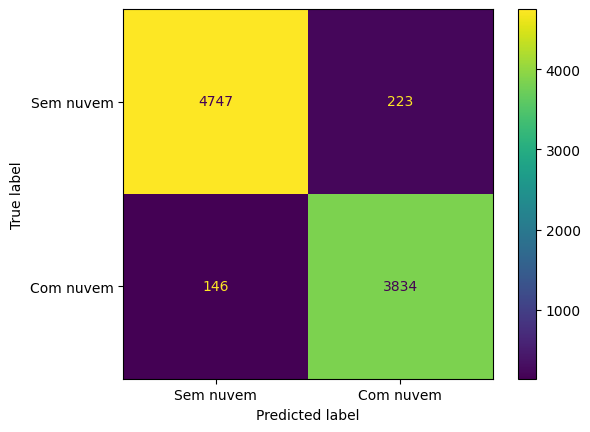

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

previsoes_modelo = y_mlppre["Predicted"]
rotulos_verdadeiros = y_mlppre["MSK_CLDPRB"]

# Definindo o threshold
threshold = 0.5

# Convertendo as previsões contínuas para previsões binárias usando o threshold
previsoes_binarias = (previsoes_modelo > threshold).astype(int)
rotulos_binarios = (rotulos_verdadeiros > threshold).astype(int)


# Criando a matriz de confusão
matriz_confusao = confusion_matrix(rotulos_binarios, previsoes_binarias)

labels = ['Sem nuvem','Com nuvem']
disp = ConfusionMatrixDisplay(matriz_confusao, display_labels=labels)
disp.plot()

report = classification_report(previsoes_binarias, rotulos_binarios)
print(report)

In [ ]:
y_mlppre

,Predicted,MSK_CLDPRB
0,0.000533,0.00
1,0.398339,0.34
2,0.637625,0.69
3,0.000449,0.00
4,0.000279,0.00
...,...,...
8945,0.769089,0.88
8946,0.952187,0.96
8947,0.057241,0.00
8948,0.593837,0.31


In [ ]:
# Let's check that we are not predicting always the same label
print(np.count_nonzero(mlppre<0.5))
print(np.count_nonzero(mlppre>=0.5))

4847
4103
